In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as sig
from scipy.signal import butter, lfilter, freqz, filtfilt, hilbert

## Hilbert envelopes with and without averaging first 

We start by making a discrete time vector, at which the signal will be sampled. 


In [3]:
time = np.arange(0, 3, 0.001) #one second of discrete time, sampled at 1000 Hz

 now, we make a time series of Brownian noise (biorealistic) time series not unlike EEG/LFP, representing one trial of neural mass data


Text(0.5, 1.0, 'One second of Brownian noise (simulated neural time series)')

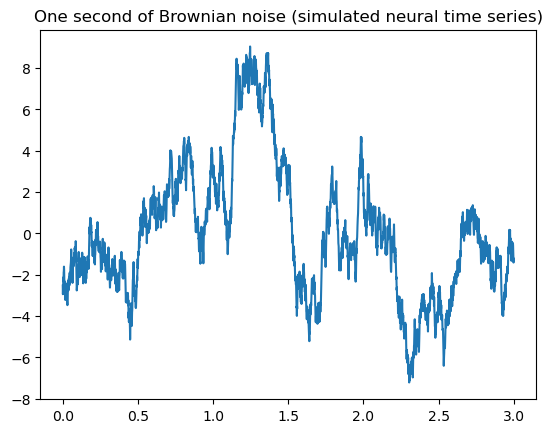

In [4]:
temp1 = np.random.uniform(low=0.0, high=1.0, size=(3000))-0.5
brownsig = np.cumsum(temp1)
brownsig  = brownsig-np.mean(brownsig)

plt.figure(1)
plt.plot(time, brownsig)
plt.title('One second of Brownian noise (simulated neural time series)')


Now we make 3 simple signals, to be added to the brownian noise.

Text(0.5, 1.0, 'One second of Brownian noise with 7.5 Hz sine wave')

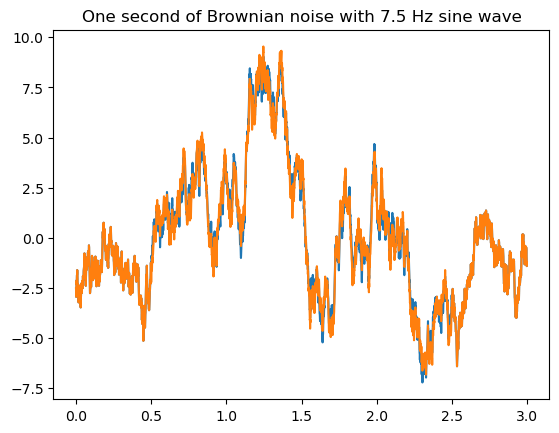

In [5]:
SNR = 0.6
Sin7_5Hz = np.sin(2*np.pi*time*7.5)*SNR # a 7.5 Hz sine wave
sumsig = brownsig.copy()
sumsig[500:2500] = brownsig[500:2500] + Sin7_5Hz[500:2500]

plt.plot(time, brownsig)
plt.title('One second of Brownian noise (simulated neural time series)')
plt.plot(time, sumsig)
plt.title('One second of Brownian noise with 7.5 Hz sine wave')

We will need this function for the next step.

In [6]:
def freqtag_HILB(data, taggingfreq, filterorder, sensor2plot, plotflag, fsamp):
    taxis = np.arange(0, data.shape[0]*1000/fsamp, 1000/fsamp)
    taxis = taxis - 1000/fsamp
    taxis = taxis/1000

    uppercutoffHz = taggingfreq + 0.5
    Blow, Alow = butter(filterorder, uppercutoffHz/(fsamp/2))

    lowercutoffHz = taggingfreq - 0.5
    Bhigh, Ahigh = butter(filterorder, lowercutoffHz/(fsamp/2), 'high')

    data = data.T

    lowpassdata = filtfilt(Blow, Alow, data)
    lowhighpassdata = filtfilt(Bhigh, Ahigh, lowpassdata)

    tempmat = hilbert(lowhighpassdata)

    tempmat = tempmat.T

    if plotflag:
        plt.figure(10)
        plt.plot(taxis, lowhighpassdata[:,sensor2plot], hold=True)
        plt.plot(taxis, np.imag(tempmat[sensor2plot, :]), 'r', hold=True)
        plt.plot(taxis, np.abs(tempmat[sensor2plot, :]), 'k', hold=True)
        plt.show(block=False)
        plt.pause(0.5)
        plt.hold(False)

    hilbamp = np.abs(tempmat)
    phase = np.angle(tempmat)
    complex_val = tempmat  # Renamed to avoid conflict with Python's built-in complex type

    return hilbamp, phase, complex_val


In [7]:
# run the function on the data
hilbamp, phase, complex = freqtag_HILB(sumsig, 7.5, 8, 1, 1, 1000)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 640x480 with 0 Axes>

Now, put everything in a loop, with 30 trials.  

- First, do averaging, then do hilbert:

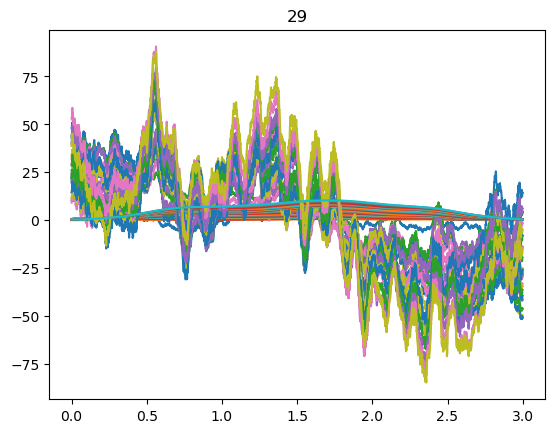

In [8]:
Sin7_5Hz = np.sin(2*np.pi*time*7.5)*SNR

avgsig = np.zeros(3000)

for trial in range(30):
    temp1 = np.random.uniform(low=0.0, high=1.0, size=(3000))-0.5
    brownsig = np.cumsum(temp1)
    brownsig  = brownsig-np.mean(brownsig)

    sumsig = brownsig.copy()
    jitter = np.random.randint(1, 31)

    sumsig[500:2500] =  brownsig[500:2500] + Sin7_5Hz[(500+jitter):(2500+jitter)]

    hilbamp, phase, complex_val = freqtag_HILB(data=sumsig, taggingfreq=7.5, filterorder=8, sensor2plot=1, plotflag=0,fsamp=1000)

    avgsig = avgsig + sumsig
    #?# hilbamp, phase, complex = freqtag_HILB(avgsig, 7.5, 8, 1, 0, 1000)
    hilbamp, phase, complex_val = freqtag_HILB(data=avgsig, taggingfreq=7.5, filterorder=8, sensor2plot=1, plotflag=0,fsamp=1000)

    plt.plot(time, avgsig)
    plt.plot(time, hilbamp)
    plt.title(str(trial))


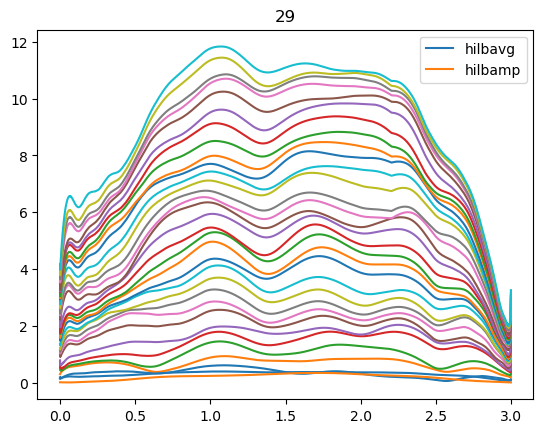

In [9]:

Sin7_5Hz = np.sin(2*np.pi*time*7.5)*SNR

hilbavg = np.zeros(3000)

for trial in range(30):
    temp1 = np.random.uniform(low=0.0, high=1.0, size=(3000))-0.5 # zero-center the white noise, because we use cumulative sum later
    brownsig = np.cumsum(temp1)  # Brownian noise is the cumulative sum of white noise
    brownsig  = brownsig-np.mean(brownsig)
    sumsig = brownsig.copy()
    jitter = np.random.randint(1, 30)
    sumsig[500:2500] = brownsig[500:2500] + Sin7_5Hz[(500+jitter):(2500+jitter)]

    #?# hilbamptrial, phase, complex = freqtag_HILB(sumsig, 7.5, 8, 1, 0, 1000)
    hilbamptrial, phase, complex_val = freqtag_HILB(data=sumsig, taggingfreq=7.5, filterorder=8, sensor2plot=1, plotflag=0,fsamp=1000)
    hilbavg = hilbavg + hilbamptrial

    plt.plot(time, hilbavg)
    plt.title(str(trial))

plt.plot(time, hilbavg/30)
plt.plot(time, hilbamp/30) # this is the same as the average of the 30 trials
plt.legend(['hilbavg', 'hilbamp'])
